In [2]:
import numpy as np
import numpy as np
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline, LinearNDInterpolator, NearestNDInterpolator
from scipy.integrate import odeint
import concurrent.futures, itertools
import matplotlib.pyplot as plt
import pickle, tqdm, functools
import vegas
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})


## Definitions and EdS case

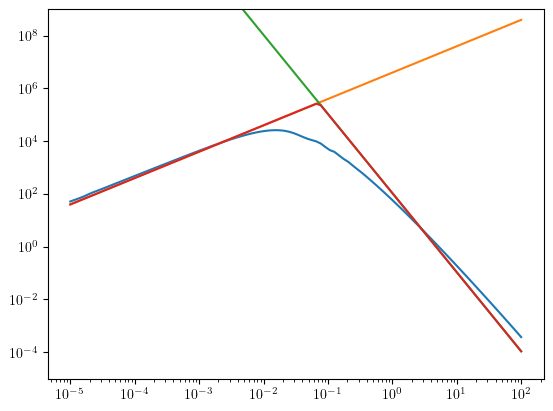

In [3]:
with open('/home/fverdian/class/soundspeed-scripts/1loop/Pk-lin-int.pkl', 'rb') as f:
    Plin_true = pickle.load(f)
fact=(2*np.pi)**3
kkk=np.logspace(-5,2,100)
plt.loglog(kkk, Plin_true(kkk))

kPiv=3.e-2
downexp=3
kup=4.e6*kkk
kdown=4.e6*(kPiv**downexp/kkk**downexp)
plt.loglog(kkk,kup)
plt.loglog(kkk,kdown)
Pmock=np.hstack((kup[kup<kdown],kdown[kup>kdown]))
Plin_int=interp1d(kkk,Pmock)
plt.loglog(kkk,Plin_int(kkk))
plt.ylim([None,1.e9]);plt.show()
Plin_int=Plin_true

In [4]:


def F3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    kPq2 = k2 + q2 + 2*k*q*mu 

    res1 = 1/kMq2*(5/126*k2-11/108*k*q*mu+7/108*q2*mu2-1/54*k2*k2*mu2/q2+4/189*k2*k*mu2*mu/q-23/756*k2*k*mu/q+25/252*k2*mu2-2/27*k*q*mu2*mu)
    res2 = 1/kPq2*(5/126*k2+11/108*k*q*mu-7/108*q2*mu2-4/27*k2*k2*mu2/q2-53/189*k2*k*mu2*mu/q+23/756*k2*k*mu/q-121/756*k2*mu2-5/27*k*q*mu2*mu)
    return res1+res2

def F2(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    return (k2*(7*k*q*mu+3*q2)-10*k2*q2*mu2)/(14*q2*kMq2)

def alpha(k1,k2,cT):
    return 1+cT*k2/k1

def alphas(k1,k2,cT):
    return 1+0.5*cT*(k2/k1+k1/k2)

def beta(k1,k2,cT):
    t1=k1*k1+k2*k2+2*k1*k2*cT
    t2=k1*k2*cT
    t3=2.*k1*k1*k2*k2
    return t1*t2/t3


In [5]:
fx=0.1
fullt=np.linspace(-8,8, 100)
teval=0
idx_eta=np.abs(fullt - (0.)).argmin()
kref=0.1

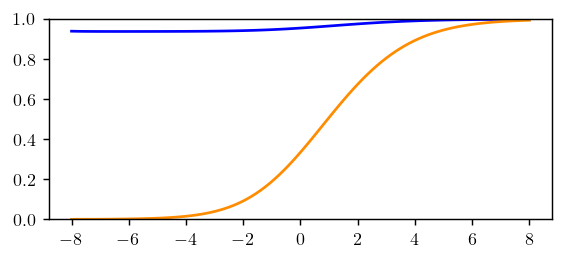

In [6]:
# this is solved fot k=0.1 (for which tildeeta = eta) and then I shift it using the smmetry
def lin_system(w,t):
    dc,Tc,dx,Tx = w
    ddcdt = Tc
    dTcdt = -0.5*Tc+1.5*(1-fx)*dc+1.5*fx*dx
    ddxdt = Tx
    dTxdt = -0.5*Tx+1.5*(1-fx)*dc+1.5*(fx-(1)*np.exp(-t))*dx
    return [ddcdt, dTcdt,ddxdt, dTxdt]
# Initial conditions
w0 = [1,1-3/5*fx,0.,0.]
# Solve the differential equation
tlin=np.linspace(fullt[0],fullt[-1],1000)

linsol = odeint(lin_system, w0, tlin)


g_c_int=interp1d(tlin,linsol[:,1]/linsol[:, 0],bounds_error=False,  fill_value=(1-3/5*fx,1))
phi_x_int=interp1d(tlin,linsol[:, 2]/linsol[:, 0],bounds_error=False, fill_value=(0.,1.))
g_x_int=interp1d(tlin,linsol[:, 3]/linsol[:, 0],bounds_error=False, fill_value=(0.,1.))
plt.figure(figsize=(5,2), dpi=130);plt.ylim([0,1])
plt.plot(fullt, g_c_int(fullt), 'b', label=r'$\Theta$')
plt.plot(fullt, phi_x_int(fullt), 'darkorange', label=r'$\delta_\chi$')
plt.show()

In [7]:
#--------
# 2nd order
#--------
def solve_second_order(triplet, return_timedep=False):
    k1 , k2, cT = triplet
    def F2_system(w, t):
        Fc2,Gc2,Fx2,Gx2 = w
        fact=(g_c_int(t-2*np.log(k1))+g_c_int(t-2*np.log(k2)))
        SF2=0.5*g_c_int(t-2*np.log(k2))*alpha(k1,k2,cT)+0.5*g_c_int(t-2*np.log(k1))*alpha(k2,k1,cT)
        dGc2dt = -(0.5+fact)*Gc2 + 1.5 *((1-fx)*Fc2+fx*Fx2) +g_c_int(t-2*np.log(k1))*g_c_int(t-2*np.log(k2))*beta(k1,k2,cT)
        dFc2dt = -fact*Fc2 + Gc2 + SF2

        SF2=0.5*phi_x_int(t-2*np.log(k1))*g_x_int(t-2*np.log(k2))*alpha(k1,k2,cT)+0.5*phi_x_int(t-2*np.log(k2))*g_x_int(t-2*np.log(k1))*alpha(k2,k1,cT)
        dFx2dt = -fact*Fx2 + Gx2 + SF2
        dGx2dt = -(0.5+fact)*Gx2 + 1.5 *((1-fx)*Fc2+(fx-(k1**2+k2**2+2*k1*k2*cT)/(kref**2)*np.exp(-t))*Fx2) +g_x_int(t-2*np.log(k1))*g_x_int(t-2*np.log(k2))*beta(k1,k2,cT)


        return [dFc2dt, dGc2dt,dFx2dt, dGx2dt]
    Fc2_0=(5./7.+6/245*fx)*alphas(k1,k2,cT)+(2./7.-6/245*fx)*beta(k1,k2,cT)
    Gc2_0=(3./7-51/245*fx)*alphas(k1,k2,cT)+(4./7-96/245*fx)*beta(k1,k2,cT)
    sol = odeint(F2_system, [Fc2_0,Gc2_0,0,0], fullt, rtol=1.e-4)
    if return_timedep:
        return sol
    return sol[idx_eta]

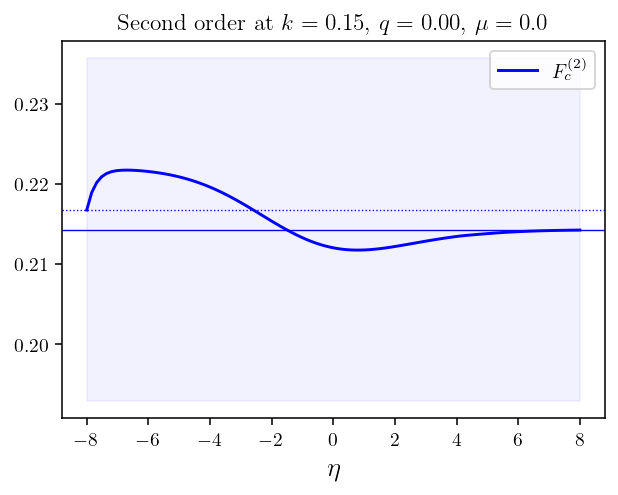

In [8]:
kp=0.15
qp=1.e-4
mup=0.
kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
cT12 = (kp*mup-qp)/kMq
sol=solve_second_order([qp,kMq,cT12], return_timedep=True)

plt.figure(figsize=(5,3.5), dpi=140)
plt.plot(fullt, sol[:,0], 'b', label=r'$F_c^{(2)}$')

# plt.plot(fullt, sol[:,1], 'darkorange', label=r'$G_c^{(2)}$')
# plt.plot(fullt, sol[:,2], linestyle='--', label=r'$F_\chi^{(2)}$')
# plt.plot(fullt, sol[:,3], linestyle='--', label=r'$G_\chi^{(2)}$')

Fc2_0=(5./7.+6/245*fx)*alphas(qp,kMq,cT12)+(2./7.-6/245*fx)*beta(qp,kMq,cT12)
plt.axhline(Fc2_0, color='b', linestyle=':', linewidth=0.7)
plt.axhline(F2(kp,qp,mup), color='b', linewidth=0.7)
plt.fill_between(fullt, F2(kp,qp,mup)*(1-fx),F2(kp,qp,mup)*(1+fx), alpha=0.05, color='b')

# plt.axhline(F3(kp,qp,mup), color='g', linewidth=0.7)

plt.legend()
# plt.xlim([-8,8])

# plt.yscale('log')
plt.title(r'Second order at $k='+'%.2f'%kp+r'$, $q='+'%.2f'%qp+r'$, $\mu='+'%.1f'%mup+r'$')
plt.xlabel(r'$\eta$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F2_kers_eta.pdf', bbox_inches='tight')

plt.show()

----
3rd order

In [9]:
#--------
# 3rd order
#--------
#--------
# 3rd order
#--------
def DeltaF3_ennio(k,q,mu):
    x2=(k/q)**2;mu2=mu*mu
    num=4*(mu2-1)*x2*(-49*mu2+(5*mu2+22)*x2 +22)
    den=945*(x2*x2+(2-4*mu2)*x2+1)
    return num/den

def G2F2combo(k1,k2,cT):
    return [(5./7+6/245*fx)*alphas(k1,k2,cT)+(2./7-6/245*fx)*beta(k1,k2,cT),(3./7-3*17/245*fx)*alphas(k1,k2,cT)+(4./7-3*32/245*fx)*beta(k1,k2,cT),0,0]

def solve_F3_for_k(triplet, return_timedep=False):
    k , q, mu = triplet
    
    if (k**2+q**2+2*k*q*mu)<10.:
        ker2_k_mq_full=solve_second_order([k,q,-mu], return_timedep=True)
        ker2_k_q_full=solve_second_order([k,q,mu], return_timedep=True)
    else:     #in case k+q is too big,  for sure is deeply hot
        ker2_k_mq_full=np.tile(G2F2combo(k,q,-mu), (fullt.shape[0], 1))
        ker2_k_q_full=np.tile(G2F2combo(k,q,mu), (fullt.shape[0], 1))
        # print('Using deep hot F2 kernels for F3 sources')

    def F3_system(w, t):

        Fc3,Gc3,Fx3,Gx3 = w
        fact=(g_c_int(t-2*np.log(k))+2*g_c_int(t-2*np.log(q)))

        idx_t_F3=np.abs(fullt - t).argmin()
        ker2_k_mq=ker2_k_mq_full[idx_t_F3]
        ker2_k_q=ker2_k_q_full[idx_t_F3]

        #F3_c and G3_c
        kMq = np.sqrt(k*k + q*q - 2*k*q*mu)
        cT=(k*mu-q)/kMq
        SF3=g_c_int(t-2*np.log(q))*alpha(q,kMq,cT)*ker2_k_mq[0]+alpha(kMq,q,cT)*ker2_k_mq[1]
        SG3=g_c_int(t-2*np.log(q))*beta(kMq,q,cT)*2*ker2_k_mq[1]
        kPq = np.sqrt(k*k + q*q + 2*k*q*mu)
        cT=-(k*mu+q)/kPq
        SF3+=g_c_int(t-2*np.log(q))*alpha(q,kPq,cT)*ker2_k_q[0]+alpha(kPq,q,cT)*ker2_k_q[1]
        SG3+=g_c_int(t-2*np.log(q))*beta(kPq,q,cT)*2*ker2_k_q[1]

        dFc3dt = -fact*Fc3 + Gc3 + SF3/3
        dGc3dt = -(0.5+fact)*Gc3 + 1.5*((1-fx)*Fc3+fx*Fx3) + SG3/3

        #F3_c and G3_c
        kMq = np.sqrt(k*k + q*q - 2*k*q*mu)
        cT=(k*mu-q)/kMq
        SF3x=g_x_int(t-2*np.log(q))*alpha(q,kMq,cT)*ker2_k_mq[2]+phi_x_int(t-2*np.log(q))*alpha(kMq,q,cT)*ker2_k_mq[3]
        SG3x=g_x_int(t-2*np.log(q))*beta(kMq,q,cT)*2*ker2_k_mq[3]
        kPq = np.sqrt(k*k + q*q + 2*k*q*mu)
        cT=-(k*mu+q)/kPq
        SF3x+=g_x_int(t-2*np.log(q))*alpha(q,kPq,cT)*ker2_k_q[2]+phi_x_int(t-2*np.log(q))*alpha(kPq,q,cT)*ker2_k_q[3]
        SG3x+=g_x_int(t-2*np.log(q))*beta(kPq,q,cT)*2*ker2_k_q[3]

        dFx3dt = -fact*Fx3 + Gx3 + SF3x/3
        dGx3dt = -(0.5+fact)*Gx3 + 1.5*((1-fx)*Fc3+(fx-(k**2)/(kref**2)*np.exp(-t))*Fx3) + SG3x/3
        return [dFc3dt, dGc3dt,dFx3dt, dGx3dt]
    
    tsol=np.linspace(np.log(k/kref)-10,np.log(k/kref)+18,100)
    tsol=fullt
    sol = odeint(F3_system, [F3(k,q,mu)-1/7*fx*DeltaF3_ennio(k,q,mu),F3(k,q,mu),0.,0.], tsol, rtol=1.e-4)
    if return_timedep:
        return [tsol,sol[:,0]]
    return sol[idx_eta,0]

In [10]:
#--------
# DEFINE MU INTEGRAL
#--------

def onmu_int(mu, kev, q, calcP13=True, calcP22=True, EdS=False):
    P13=0
    if calcP13:
        if EdS:
            F3_val=F3(kev,q,mu)
        else:
            F3_val=solve_F3_for_k([kev,q,mu])
            print(f'q={q:.1e},F3={F3_val} in EdS was {F3(kev,q,mu)}')
        P13+=6*q*q*F3_val*Plin_int(q)#*Plin_int(kev)
    kMq = np.sqrt(kev*kev + q*q - 2*kev*q*mu)
    kPq = np.sqrt(kev*kev + q*q + 2*kev*q*mu)
    P22=0
    if calcP22:
        if kMq>q:
            if EdS:
                F2_val=F2(kev,q,mu)
            else:
                cT12 = (kev*mu-q)/kMq
                F2_val=solve_second_order([q,kMq,cT12])[0]
            P22+=2*q*q*F2_val*F2_val*Plin_int(q)*Plin_int(kMq)
        if kPq>q:
            if EdS:
                F2_val=F2(kev,q,-mu)
            else:
                cT12 = -(kev*mu+q)/kPq
                F2_val=solve_second_order([q,kPq,cT12])[0]
            P22+=2*q*q*F2_val*F2_val*Plin_int(q)*Plin_int(kPq)
    return (P13+P22)*4*np.pi/fact
    


q=1.0e-02,F3=-35.7005356211055 in EdS was -37.5
q=1.4e-02,F3=-17.263905468357866 in EdS was -18.123488394644067
q=2.1e-02,F3=-8.351578608987372 in EdS was -8.758955509087956
q=3.0e-02,F3=-4.042742310117053 in EdS was -4.2331420938175865
q=4.3e-02,F3=-1.9591674118199613 in EdS was -2.0458480429381956
q=6.2e-02,F3=-0.9511477428966648 in EdS was -0.9887440870238842
q=8.9e-02,F3=-0.4629351361484912 in EdS was -0.4778531196386756
q=1.3e-01,F3=-0.22573713885469374 in EdS was -0.2309430791497595
q=1.8e-01,F3=-0.11004557221820475 in EdS was -0.11161317906117457
q=2.6e-01,F3=-0.05440297118977792 in EdS was -0.05394187081078727
q=3.8e-01,F3=-0.027213111179294248 in EdS was -0.02606972985665855
q=5.5e-01,F3=-0.013510011088981623 in EdS was -0.012599318573564194
q=7.8e-01,F3=-0.006380364107307642 in EdS was -0.006089162771957708
q=1.1e+00,F3=0.00016814616426153117 in EdS was -0.002942849888817954
q=1.6e+00,F3=-0.004382349138485992 in EdS was -0.001422258821524608
q=2.3e+00,F3=-0.002036968763205354

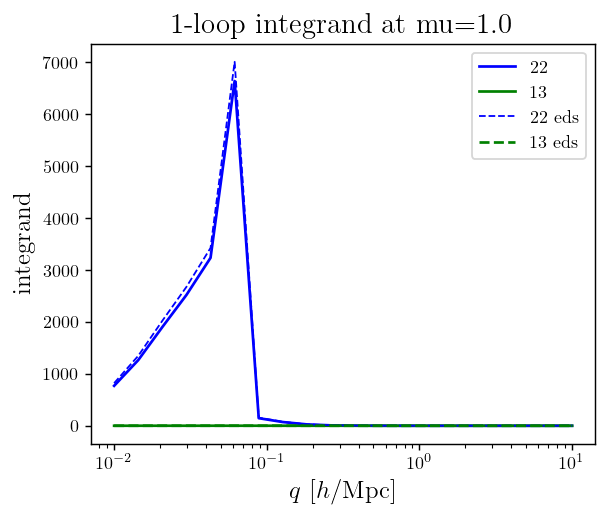

In [13]:
mu=1.
kev=0.15
qlist=np.logspace(-2,1,20)

res22=[];res13=[]
for q in qlist:
    print(f'q={q:.1e}', end='\r')
    res22.append(q*onmu_int(mu, kev, q, calcP13=False, calcP22=True, EdS=False))
    res13.append(q*onmu_int(mu, kev, q, calcP13=True, calcP22=False, EdS=False))
res22=np.array(res22);res13=np.array(res13);

plt.figure(figsize=(5,4), dpi=130)
plt.plot(qlist,res22,'b',label='22')
plt.plot(qlist,np.abs(res13),'g',label='13')

res22=[];res13=[]
for q in qlist:
    print(f'q={q:.1e}', end='\r')
    res22.append(q*onmu_int(mu, kev, q, calcP13=False, calcP22=True, EdS=True))
    res13.append(q*onmu_int(mu, kev, q, calcP13=True, calcP22=False, EdS=True))
res22=np.array(res22);res13=np.array(res13);
plt.plot(qlist,res22,'b--',label='22 eds', linewidth=1)
plt.plot(qlist,np.abs(res13),'g--',label='13 eds')


plt.xlabel(r"$q$ [$h/\mathrm{Mpc}$]", fontsize=14)
plt.ylabel(r'integrand', fontsize=14)
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title(f'1-loop integrand at mu={mu:.1f}', fontsize=16)

plt.show()

In [ ]:
kp=0.15
qp=79
mup=1.
print(solve_F3_for_k([kp,qp,mup]))


0.0001610485190786862


In [ ]:
kp=0.15
qp=1.e-4
integ = vegas.Integrator([0., 1.],mpi=True, nproc=48)
result = integ(functools.partial(onmu_int, kev=kp, q=qp,calcP22=True, calcP13=False, EdS=False),neval=100)
res22=result.mean
print(f'P22={result},now P13')
result = integ(functools.partial(onmu_int, kev=kp, q=qp,calcP22=False, calcP13=True,EdS=False),neval=100)
res13=result.mean
print(f'P13={result}')
print(f'P22={res22:.3f}, -P13={-res13:.3f}, reldiff={(res22+res13)/res22:.0e}')

 P22=483.9(1.4),now P13
P13=-509.5(1.9)
P22=483.864, -P13=509.450, reldiff=-5e-02 

In [ ]:
reslist22=[];reslist13=[]
kp=0.15
qlist=np.logspace(-5,-2,4)
# for qEval in qlist:
#     print(f'P22 at q={qEval:.2e}',end='\r')
#     integ = vegas.Integrator([0., 1.],mpi=True, nproc=48)
#     result = integ(functools.partial(onmu_int, kev=kp, q=qEval,calcP22=True, calcP13=False, EdS=False),neval=50)
#     reslist22.append(result.mean)

#     print(f'P13 at q={qEval:.2e}',end='\r')
#     result = integ(functools.partial(onmu_int, kev=kp, q=qEval,calcP22=False, calcP13=True,EdS=False),neval=50)
#     reslist13.append(result.mean)

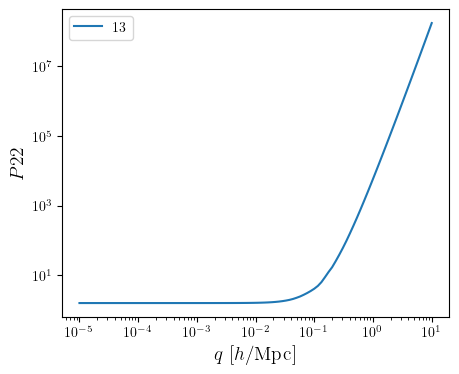

In [19]:
plt.figure(figsize=(5,4), dpi=100)
# plt.plot(qlist,reslist22,label='22')
# plt.plot(qlist,np.abs(np.array(reslist13)),label='13')
plt.plot(qlist,np.abs(reslist22-np.abs(np.array(reslist13)))/reslist22,label='13')

plt.xlabel(r"$q$ [$h/\mathrm{Mpc}$]", fontsize=14)
plt.ylabel(r'$P22$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.show()